In [1]:
from moseq2_detectron_extract.io.annot import default_keypoint_names, register_datasets, read_annotations, show_dataset_info,augment_annotations_with_rotation
from moseq2_detectron_extract.viz import visualize_annotations
from moseq2_detectron_extract.model.config import get_base_config, add_dataset_cfg
import cv2
from detectron2.data import MetadataCatalog
from moseq2_detectron_extract.model.model import Trainer, MoseqDatesetMapper, Predictor
import os
import datetime
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data.detection_utils import convert_image_to_rgb
import pycocotools

import sys

In [2]:
os.chdir("C:\\Users\\MHaas\\Projects\\detectron2\\mask_keypoints_for_michael")
annot_file = "result.json"

In [3]:
cfg = get_base_config()

In [4]:
annotations = read_annotations(annot_file, default_keypoint_names, mask_format=cfg.INPUT.MASK_FORMAT)
print(len(annotations))
annotations = augment_annotations_with_rotation(annotations)
show_dataset_info(annotations)

seed = 27
random.seed(seed)

register_datasets(annotations, default_keypoint_names)

472
Num Items:  1888
Image size range:  ((244, 250), (240, 250))
Width: 14.88/50.50/92.82
Height: 14.88/54.78/92.33
None


In [5]:
#Original configuration
cfg = add_dataset_cfg(cfg)
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('moseq_test',)
  TRAIN: ('moseq_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: L
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 250
  MAX_SIZE_TRAIN: 250
  MIN_SIZE_TEST: 240
  MIN_SIZE_TRAIN: (240,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: none
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURES: ['res2', 'res3', 'res4', 'res5']
    NORM: 
    OU

In [6]:
def add_config(cfg_list, out_dir, name):
    cfg = get_base_config()
    cfg = add_dataset_cfg(cfg)
    
    cfg.SOLVER.MAX_ITER=5000
    cfg.SOLVER.STEPS=()
    cfg.SOLVER.CHECKPOINT_PERIOD = 2500
    #cfg.SOLVER.IMS_PER_BATCH=4
    
    #cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE=8#Unless rearing, should always have 'Nose','Left Ear', 'Right Ear', 'Neck', 'Left Hip', 'Right Hip', 'TailBase', and 'TailTip'
    
    cfg.OUTPUT_DIR = os.path.join(out_dir,name)
    cfg_list.append(cfg)
    return cfg_list

In [7]:
out_dir = os.path.join(cfg.OUTPUT_DIR, "h_param_tests_"+datetime.datetime.now().strftime("%Y-%m-%dT%H-%M_%S"))
cfg_list = []

cfg_list = add_config(cfg_list, out_dir, "Default")

cfg_list = add_config(cfg_list, out_dir, "lr_025")
cfg_list[-1].SOLVER.BASE_LR = 0.025

cfg_list = add_config(cfg_list, out_dir, "lr_00025")
cfg_list[-1].SOLVER.BASE_LR = 0.00025

cfg_list = add_config(cfg_list, out_dir, "8_min_keys_per_im")
#Unless rearing, should always have 'Nose','Left Ear', 'Right Ear', 'Neck', 'Left Hip', 'Right Hip', 'TailBase', and 'TailTip'
cfg_list[-1].MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE=8#Filters out instances < 8 from dataset

cfg_list = add_config(cfg_list, out_dir, "ROI_bpi_128")
cfg_list[-1].MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

cfg_list = add_config(cfg_list, out_dir, "ROI_bpi_64")
cfg_list[-1].MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

cfg_list = add_config(cfg_list, out_dir, "ROI_bpi_32")
cfg_list[-1].MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32

cfg_list = add_config(cfg_list, out_dir, "RPN_bpi_128")
cfg_list[-1].MODEL.RPN.BATCH_SIZE_PER_IMAGE = 128

cfg_list = add_config(cfg_list, out_dir, "RPN_bpi_64")
cfg_list[-1].MODEL.RPN.BATCH_SIZE_PER_IMAGE = 64

cfg_list = add_config(cfg_list, out_dir, "RPN_bpi_32")
cfg_list[-1].MODEL.RPN.BATCH_SIZE_PER_IMAGE = 32

'''cfg_list = add_config(cfg_list, out_dir, "ROI_score_thresh_01")
cfg_list[-1].MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01

cfg_list = add_config(cfg_list, out_dir, "ROI_score_thresh_1")
cfg_list[-1].MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1'''

'''cfg_list = add_config(cfg_list, out_dir, "ROI_NMS_thresh_25")
cfg_list[-1].MODEL.ROI_HEADS.SCORE_NMS_TEST = 0.25

cfg_list = add_config(cfg_list, out_dir, "ROI_NMS_thresh_75")
cfg_list[-1].MODEL.ROI_HEADS.SCORE_NMS_TEST = 0.75'''

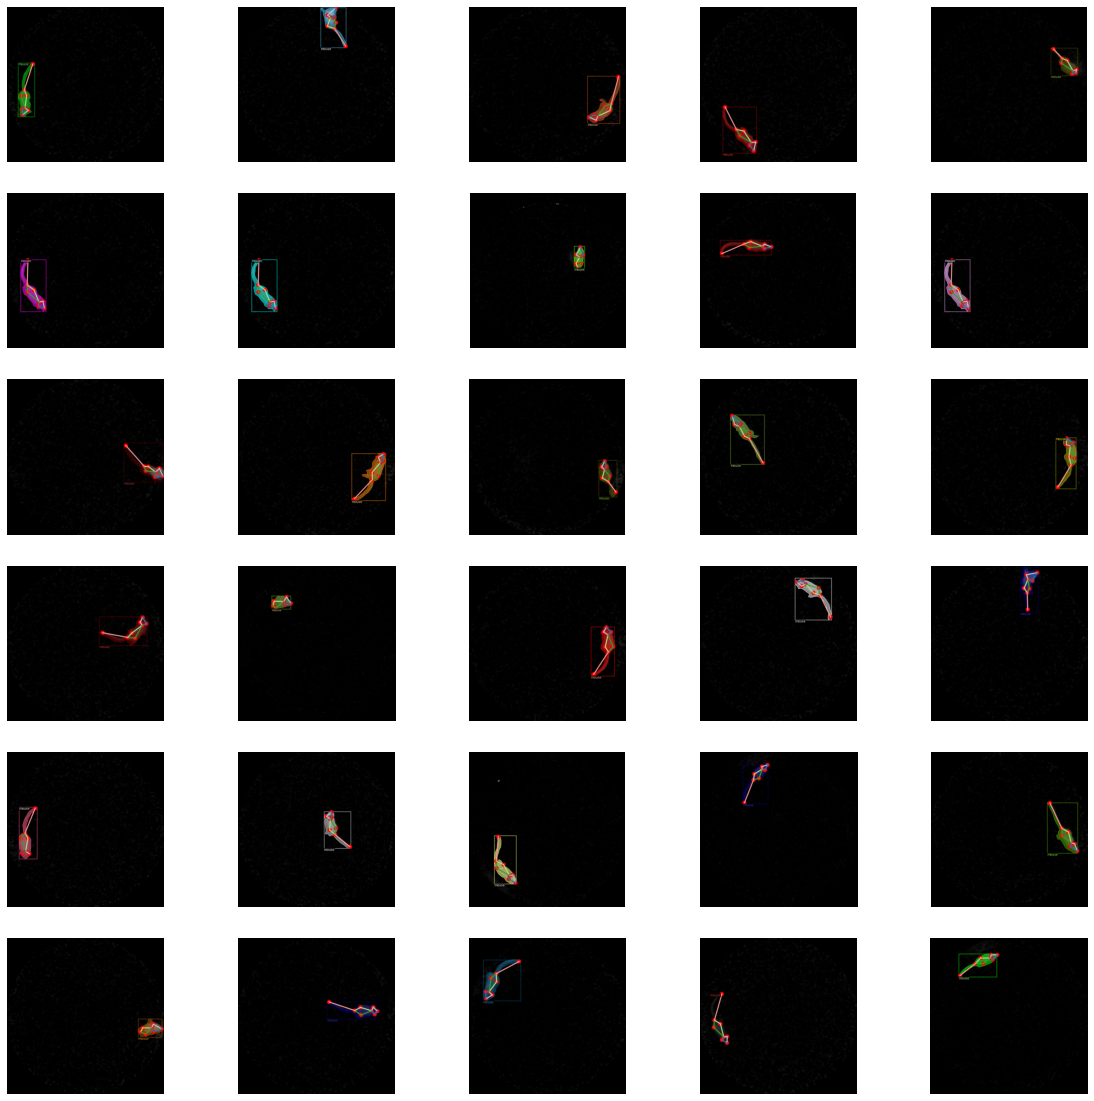

In [8]:
rows = 6
columns = 5
fig = plt.figure(figsize=(20,20))
for d, i in zip(random.sample(annotations, rows*columns),range(1,rows*columns+1)):
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:,:,::-1],
                   metadata=MetadataCatalog.get("moseq_train"),
                   scale=2.0,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(out.get_image())
plt.show()

Model output: ./models/output_4\h_param_tests_2021-07-09T04-23_30\Default
Printing temporarily disabled, please wait.


Skip loading parameter 'backbone.bottom_up.stem.conv1.weight' to the model due to incompatible shapes: (64, 3, 7, 7) in the checkpoint but (64, 1, 7, 7) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 8, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.stem.conv1.weight
roi_heads.keypoint_head.score_lowres.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mas

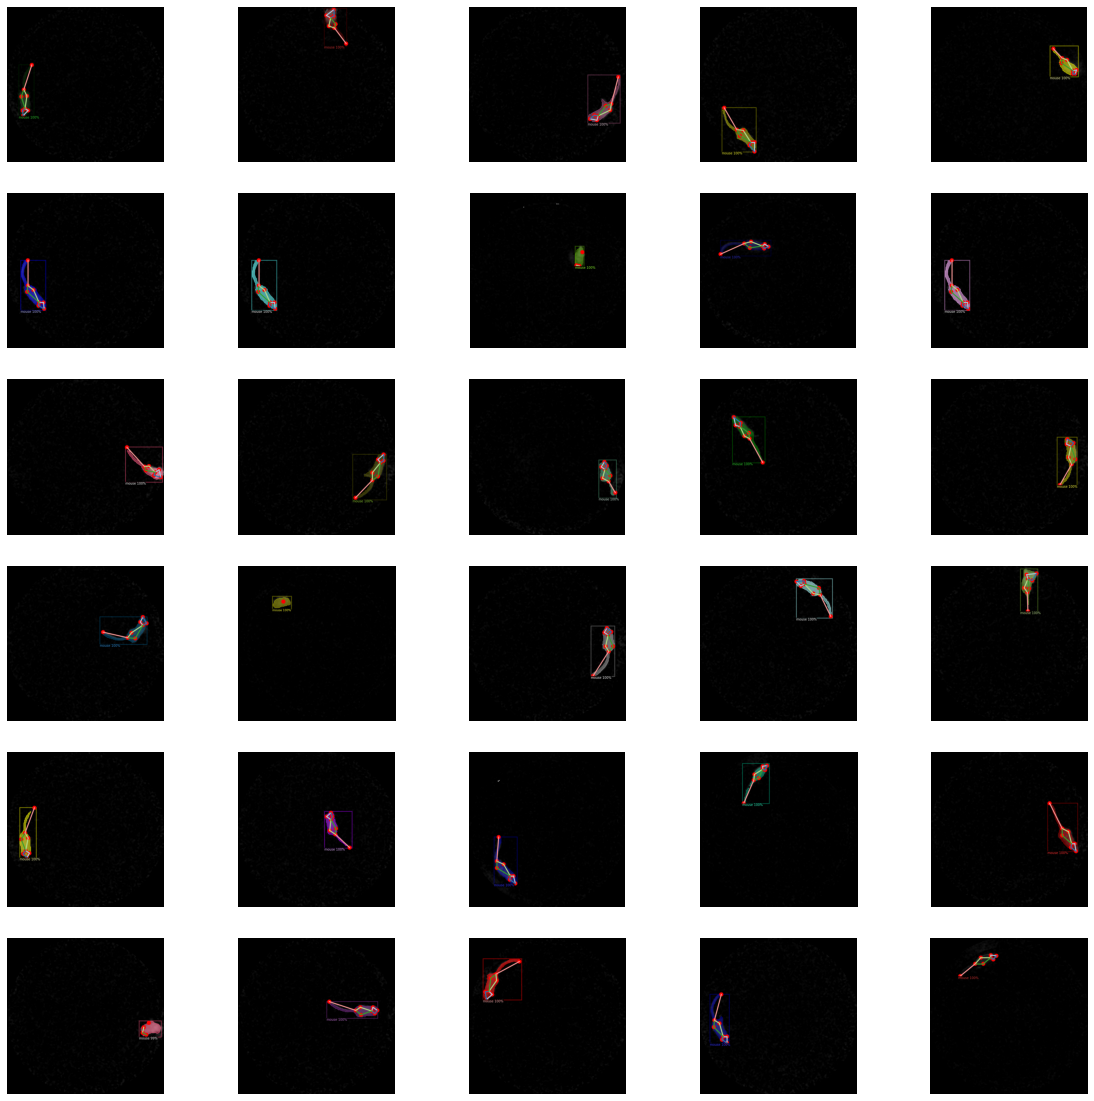

Skip loading parameter 'backbone.bottom_up.stem.conv1.weight' to the model due to incompatible shapes: (64, 3, 7, 7) in the checkpoint but (64, 1, 7, 7) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 8, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.stem.conv1.weight
roi_heads.keypoint_head.score_lowres.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mas

FloatingPointError: Predicted boxes or scores contain Inf/NaN. Training has diverged.

In [9]:
for cfg in cfg_list:
    #Training
    print("Model output: {}".format(cfg.OUTPUT_DIR))
    print("Printing temporarily disabled, please wait.")
    sys.stdout = open(os.devnull, 'w')#Block trainer prints
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
    with open(os.path.join(cfg.OUTPUT_DIR, "config.yaml"), 'w') as f:
        f.write(cfg.dump())

    trainer = Trainer(cfg)
    trainer.resume_or_load(resume=True)
    trainer.train()
    
    #Inference
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR,  'model_final.pth') #"model_final.pth")  # path to the model we just trained     "model_0001999.pth")#
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
    cfg.TEST.DETECTIONS_PER_IMAGE = 1
    predictor = Predictor(cfg)
    
    sys.stdout = sys.__stdout__#Restore printing
    
    #rows = 6
    #columns = 5
    fig = plt.figure(figsize=(20,20))
    random.seed(seed)
    for d, i in zip(random.sample(annotations, rows*columns),range(1,rows*columns+1)):
        im = cv2.imread(d["file_name"])[:,:,0,None]
        #outputs = predictor(im)[0]  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        #above format was creating a KeyError
        outputs = predictor(im)
        #print(outputs)

        v = Visualizer(convert_image_to_rgb(im, "L"),
                       metadata=MetadataCatalog.get("moseq_train"), 
                       scale=2.0, 
                       instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(out.get_image())
    fig.savefig(os.path.join(cfg.OUTPUT_DIR,"inference.png"))
    plt.show()